In [99]:
# Import all this

import clean_up_data
import regression_df
import get_data
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
import copy

# DO NOT run below code. Scroll down to the read_csv statements instead

In [3]:
# set an n value for number of games to average over
n = 10

In [108]:
# get the data real quick (train on 2016,2017, test on 2018)
games15 = get_data.get_data_for_year(2015)
games16 = get_data.get_data_for_year(2016)

games17 = get_data.get_data_for_year(2017)

dic15 = clean_up_data.main(games15)
dic16 = clean_up_data.main(games16)

dic17 = clean_up_data.main(games17)

regr15 = regression_df.main(dic15)
regr16 = regression_df.main(dic16)

regr17 = regression_df.main(dic17)


[INFO] Lost 503 values.
[INFO] Lost 64 values.
[INFO] Lost 108 values.


In [109]:
# quick function to turn our regression data ready for actual regression

def prepare(regr):
    home = regr[regr['home']]
    away = regr[regr['home'] == False]
    # drop columns that don't need repeating
    away.drop(['home','t1_score', 't2_score', 'game_spread',
       'game_OU', 't1_ML', 't2_ML'], axis = 1, inplace = True)
    home.drop(['home'], axis = 1, inplace = True)
    return home.merge(away, on = 'game_id', suffixes=('_home', '_away'))    

In [110]:
data15 = prepare(regr15)
data16 = prepare(regr16)

data17 = prepare(regr17)

train = pd.concat((data15, data16))
test = data17

## Run code starting here

In [173]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Breakdown of prepared regression data: Our columns are


       'game_id', 'pts_home', 'a_pts_home', 'poss_home', 'a_poss_home',
       'ort_home', 'drt_home', 'OU_home', 'efg_home', 'a_efg_home',
       'ast_pct_home', 'win_home', 
       
       't1_score', 't2_score', 'game_spread',
       'game_OU', 't1_ML', 't2_ML',
       
       'pts_away', 'a_pts_away', 'poss_away',
       'a_poss_away', 'ort_away', 'drt_away', 'OU_away', 'efg_away',
       'a_efg_away', 'ast_pct_away', 'win_away'
       
The first and third parts are the home & away statistics, averaged (or calculated) over n games.The prefix a_ means the statistics is calculated for the team's opponents. 

The middle part contains the details of the game results as well as gambling info for the games.

# Algorithm 1

We perform a linear regression on the cover, using game stats which we deem important

In [96]:
# relevant columns
X_cols = ['pts', 'a_pts', 'poss', 'a_poss',
   'ort', 'drt', 'efg', 'a_efg',
   'ast_pct']
X_cols = [x + '_home' for x in X_cols] + [x + '_away' for x in X_cols]

In [111]:
X_train = train[X_cols]
X_test = test[X_cols]
y_train = train['t1_score'] - train['t2_score'] - train['game_spread']
y_test = test['t1_score'] - test['t2_score'] - test['game_spread']

In [112]:
lr = LinearRegression()

In [113]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [114]:
pred = lr.predict(X_test)

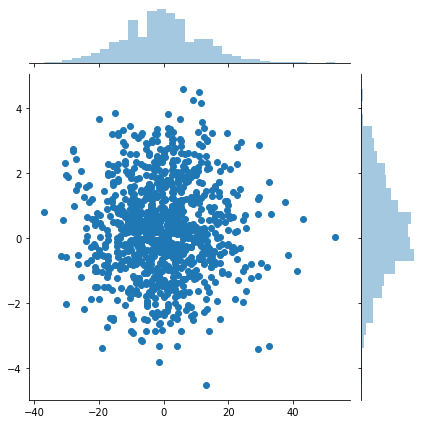

In [115]:
sns.jointplot(x = y_test, y = pred)

In [116]:
print(classification_report(y_test > 0, pred > 0))

              precision    recall  f1-score   support

       False       0.54      0.45      0.49       519
        True       0.47      0.55      0.51       447

    accuracy                           0.50       966
   macro avg       0.50      0.50      0.50       966
weighted avg       0.51      0.50      0.50       966



Awesome, didn't work at all!

# Algorithm 2
Now we predict the points total for both teams, and see if that covers the spread!

In [132]:
# relevant columns
X_cols = ['pts', 'a_pts', 'poss', 'a_poss',
   'ort', 'drt', 'efg', 'a_efg',
   'ast_pct']
X_cols = [x + '_home' for x in X_cols] + [x + '_away' for x in X_cols]

In [133]:
X_train = train[X_cols]
X_test = test[X_cols]
y_train = train[['t1_score', 't2_score']]
y_test = test[['t1_score', 't2_score']]

In [134]:
lr = LinearRegression()

In [135]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [136]:
pred = lr.predict(X_test)

In [141]:
guesses = pd.DataFrame(pred)
pred_cover = guesses[0] - guesses[1] - test['game_spread']
y_test_cover = y_test['t1_score'] - y_test['t2_score'] - test['game_spread']

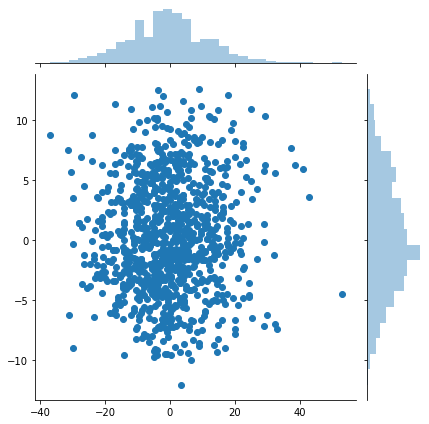

In [142]:
sns.jointplot(x = y_test_cover, y = pred_cover)

In [143]:
print(classification_report(y_test_cover > 0, pred_cover > 0))

              precision    recall  f1-score   support

       False       0.56      0.53      0.54       519
        True       0.49      0.52      0.50       447

    accuracy                           0.52       966
   macro avg       0.52      0.52      0.52       966
weighted avg       0.53      0.52      0.53       966



52%, unreal!

# Algorithm 3

This time, we use the data to predict what the spread is, and if our predicted spread is higher than the actual spread, we bet on the favorite (lower: bet on underdog).

In [177]:
# relevant columns
X_cols = ['pts', 'a_pts', 'poss', 'a_poss',
   'ort', 'drt', 'efg', 'a_efg',
   'ast_pct']
X_cols = [x + '_home' for x in X_cols] + [x + '_away' for x in X_cols]

In [178]:
X_train = train[X_cols]
X_test = test[X_cols]
y_train = train['game_spread']
y_test = test['game_spread']

In [179]:
lr = LinearRegression()

In [180]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [181]:
pred = lr.predict(X_test)

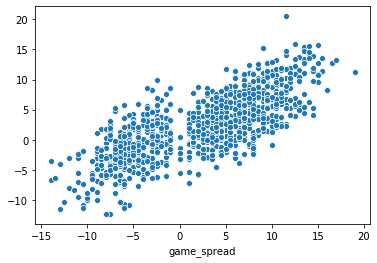

In [204]:
sns.scatterplot(x = y_test, y = pred)

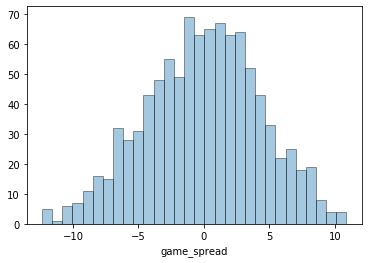

In [212]:
sns.distplot(y_test - pred, bins = 30, kde = False, norm_hist = False, hist_kws = {'edgecolor' : 'black'})

In [151]:
cover = (test['t1_score'] - test['t2_score'] - test['game_spread']) > 0

In [152]:
print(classification_report(cover, pred > test['game_spread']))

              precision    recall  f1-score   support

       False       0.54      0.51      0.52       519
        True       0.47      0.50      0.48       447

    accuracy                           0.50       966
   macro avg       0.50      0.50      0.50       966
weighted avg       0.51      0.50      0.50       966



SHIT

# Algorithm 4

Now we just use a logistic regression to classify cover

In [267]:
# relevant columns
X_cols = ['pts', 'a_pts', 'poss', 'a_poss',
   'ort', 'drt', 'efg', 'a_efg',
   'ast_pct']
X_cols = [x + '_home' for x in X_cols] + [x + '_away' for x in X_cols]

In [268]:
X_train = train[X_cols]
X_test = test[X_cols]
y_train = (train['t1_score'] - train['t2_score'] - train['game_spread']) > 0
y_test = (test['t1_score'] - test['t2_score'] - test['game_spread']) > 0

In [249]:
lr = LogisticRegression()

In [250]:
lr.fit(X_train, y_train)

C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [251]:
pred = lr.predict(X_test)

In [253]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.55      0.52      0.53       519
        True       0.47      0.49      0.48       447

    accuracy                           0.51       966
   macro avg       0.51      0.51      0.51       966
weighted avg       0.51      0.51      0.51       966



trash!

In [255]:
from tensorflow.keras import layers